In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline

import yaml
from nnaps import predictors
from sklearn import metrics

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../../data/processed/sdBShortP_large_BPS_set_stability_VAR_alphace_VAR_processed_ce_applied.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49461 entries, 0 to 49460
Columns: 110 entries, path to product
dtypes: bool(5), float64(86), int64(10), object(9)
memory usage: 39.9+ MB


In [4]:
df['stability'].value_counts()

stable              17893
CE                  11320
contact              7730
late-interaction     7654
merger               4864
Name: stability, dtype: int64

In [5]:
df['product'].value_counts()

He-WD    18593
HB       14809
UK       12594
sdB       3465
Name: product, dtype: int64

In [6]:
df_ce = df[df['stability'] == 'CE']
df_merger = df[df['stability'] == 'merger']
df_stable = df[(df['stability'] == 'stable')]
df_he = df_stable[df_stable['HeCoreBurning'] == 1]

In [7]:
df_ce['product'].value_counts()

He-WD    9397
HB       1102
sdB       821
Name: product, dtype: int64

## Predict stability

In [8]:
setup = """
features: 
    - M1_init
    - q_init
    - P_init
    - FeH_init
    - stability_limit
    - alpha_ce
regressors: []
classifiers: 
    - stability
model:
   - {'layer':'Dense',   'args':[300], 'kwargs': {'activation':'relu', 'name':'FC_1'} }
   - {'layer':'Dense',   'args':[200], 'kwargs': {'activation':'relu', 'name':'FC_2'} }
   - {'layer':'Dense',   'args':[100], 'kwargs': {'activation':'relu', 'name':'FC_3'} }
   - {'layer':'Dense',   'args':[50],  'kwargs': {'activation':'relu', 'name':'FC_4'} }
optimizer: adam
"""
setup = yaml.safe_load(setup)

In [9]:
predictor_stability = predictors.FCPredictor(setup=setup, data=df)

In [10]:
predictor_stability.fit(epochs=100, batch_size=2048, reduce_lr=True)

Train on 39568 samples, validate on 9893 samples
Epoch 1/100
 - 2s - loss: 1.3069 - accuracy: 0.5185 - val_loss: 0.9482 - val_accuracy: 0.6317
Epoch 2/100
 - 2s - loss: 0.8033 - accuracy: 0.6925 - val_loss: 0.7180 - val_accuracy: 0.7228
Epoch 3/100
 - 2s - loss: 0.6629 - accuracy: 0.7424 - val_loss: 0.6251 - val_accuracy: 0.7507
Epoch 4/100
 - 2s - loss: 0.5863 - accuracy: 0.7703 - val_loss: 0.5652 - val_accuracy: 0.7758
Epoch 5/100
 - 2s - loss: 0.5281 - accuracy: 0.7945 - val_loss: 0.5250 - val_accuracy: 0.7913
Epoch 6/100
 - 2s - loss: 0.4860 - accuracy: 0.8082 - val_loss: 0.4725 - val_accuracy: 0.8126
Epoch 7/100
 - 2s - loss: 0.4463 - accuracy: 0.8251 - val_loss: 0.4410 - val_accuracy: 0.8238
Epoch 8/100
 - 1s - loss: 0.4154 - accuracy: 0.8373 - val_loss: 0.4175 - val_accuracy: 0.8318
Epoch 9/100
 - 2s - loss: 0.3881 - accuracy: 0.8479 - val_loss: 0.3859 - val_accuracy: 0.8464
Epoch 10/100
 - 2s - loss: 0.3676 - accuracy: 0.8558 - val_loss: 0.3674 - val_accuracy: 0.8530
Epoch 11/1

Epoch 86/100
 - 1s - loss: 0.1676 - accuracy: 0.9274 - val_loss: 0.2092 - val_accuracy: 0.9043
Epoch 87/100
 - 1s - loss: 0.1661 - accuracy: 0.9285 - val_loss: 0.2084 - val_accuracy: 0.9051
Epoch 88/100
 - 2s - loss: 0.1661 - accuracy: 0.9293 - val_loss: 0.2098 - val_accuracy: 0.9041
Epoch 89/100
 - 2s - loss: 0.1662 - accuracy: 0.9277 - val_loss: 0.2076 - val_accuracy: 0.9054
Epoch 90/100
 - 1s - loss: 0.1655 - accuracy: 0.9288 - val_loss: 0.2070 - val_accuracy: 0.9050
Epoch 91/100
 - 1s - loss: 0.1654 - accuracy: 0.9286 - val_loss: 0.2088 - val_accuracy: 0.9060
Epoch 92/100
 - 2s - loss: 0.1659 - accuracy: 0.9293 - val_loss: 0.2119 - val_accuracy: 0.9032
Epoch 93/100
 - 2s - loss: 0.1656 - accuracy: 0.9298 - val_loss: 0.2097 - val_accuracy: 0.9038
Epoch 94/100
 - 1s - loss: 0.1660 - accuracy: 0.9289 - val_loss: 0.2075 - val_accuracy: 0.9054
Epoch 95/100
 - 1s - loss: 0.1649 - accuracy: 0.9292 - val_loss: 0.2072 - val_accuracy: 0.9054

Epoch 00095: ReduceLROnPlateau reducing learning 

Training results
target           mean  training score   test score
--------------------------------------------------
stability   :  -        93.1%        90.5%


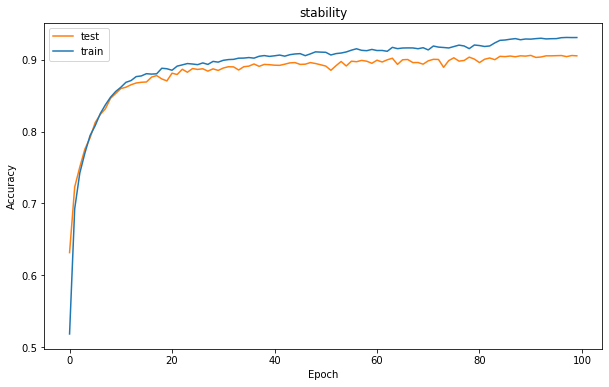

In [11]:
pl.figure(figsize=(10,6))
predictor_stability.print_score()
predictor_stability.plot_training_history()

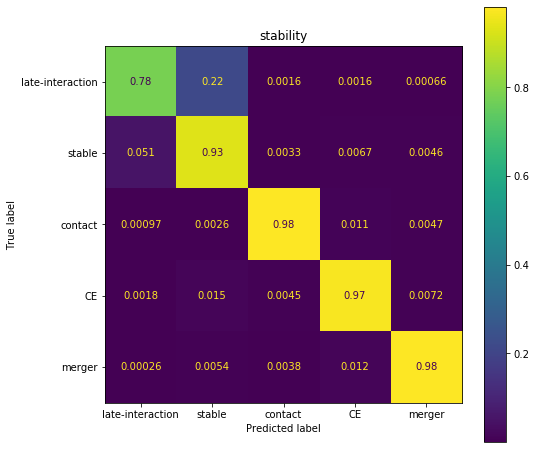

In [12]:
pl.figure(figsize=(8, 8))
predictor_stability.plot_confusion_matrix()

In [13]:
predictor_stability.save_model('model_stability.h5')

## Predict properties for stable systems

Oversample the sdBs

In [14]:
df_stable['product'].value_counts()

He-WD    9196
HB       6130
sdB      2567
Name: product, dtype: int64

In [15]:
df_stable_sdb = df_stable[df_stable['product'] == 'sdB'].sample(5000, replace=True)
df_stable_resampled = pd.concat([df_stable, df_stable_sdb])
df_stable_resampled['product'].value_counts()

He-WD    9196
sdB      7567
HB       6130
Name: product, dtype: int64

In [16]:
setup = """
features: 
    - M1_init
    - q_init
    - P_init
    - FeH_init
regressors:
    P_final:
        processor: StandardScaler
    q_final:
        processor: StandardScaler
    M1_final:
        processor: StandardScaler
classifiers: 
    - product
model:
   - {'layer':'Dense',   'args':[200], 'kwargs': {'activation':'relu', 'name':'FC_1'} }
   - {'layer':'Dense',   'args':[100], 'kwargs': {'activation':'relu', 'name':'FC_2'} }
   - {'layer':'Dense',   'args':[50],  'kwargs': {'activation':'relu', 'name':'FC_3'} }
   
optimizer: adam
"""
setup = yaml.safe_load(setup)
predictor_stable = predictors.FCPredictor(setup=setup, data=df_stable_resampled)

In [17]:
predictor_stable.fit(epochs=100, batch_size=1024, reduce_lr=True)

Train on 18314 samples, validate on 4579 samples
Epoch 1/100
 - 3s - loss: 3.0136 - P_final_loss: 0.5825 - q_final_loss: 0.5072 - M1_final_loss: 0.8358 - product_loss: 1.0824 - P_final_mae: 0.6164 - q_final_mae: 0.2277 - M1_final_mae: 0.3254 - product_accuracy: 0.4097 - val_loss: 2.2600 - val_P_final_loss: 0.3087 - val_q_final_loss: 0.1272 - val_M1_final_loss: 0.7487 - val_product_loss: 1.0456 - val_P_final_mae: 0.4378 - val_q_final_mae: 0.1762 - val_M1_final_mae: 0.2957 - val_product_accuracy: 0.5259
Epoch 2/100
 - 1s - loss: 1.9909 - P_final_loss: 0.2276 - q_final_loss: 0.0646 - M1_final_loss: 0.7133 - product_loss: 0.9839 - P_final_mae: 0.3728 - q_final_mae: 0.1439 - M1_final_mae: 0.2593 - product_accuracy: 0.6266 - val_loss: 1.7941 - val_P_final_loss: 0.1572 - val_q_final_loss: 0.0409 - val_M1_final_loss: 0.6764 - val_product_loss: 0.8927 - val_P_final_mae: 0.3066 - val_q_final_mae: 0.1135 - val_M1_final_mae: 0.2664 - val_product_accuracy: 0.6967
Epoch 3/100
 - 1s - loss: 1.6379 - 

Epoch 19/100
 - 1s - loss: 0.7709 - P_final_loss: 0.0372 - q_final_loss: 0.0173 - M1_final_loss: 0.4994 - product_loss: 0.2193 - P_final_mae: 0.1119 - q_final_mae: 0.0579 - M1_final_mae: 0.2081 - product_accuracy: 0.9168 - val_loss: 0.8004 - val_P_final_loss: 0.0345 - val_q_final_loss: 0.0214 - val_M1_final_loss: 0.5281 - val_product_loss: 0.2040 - val_P_final_mae: 0.1064 - val_q_final_mae: 0.0630 - val_M1_final_mae: 0.2208 - val_product_accuracy: 0.9240
Epoch 20/100
 - 1s - loss: 0.7639 - P_final_loss: 0.0359 - q_final_loss: 0.0179 - M1_final_loss: 0.4949 - product_loss: 0.2148 - P_final_mae: 0.1058 - q_final_mae: 0.0603 - M1_final_mae: 0.2173 - product_accuracy: 0.9188 - val_loss: 0.7888 - val_P_final_loss: 0.0343 - val_q_final_loss: 0.0224 - val_M1_final_loss: 0.5210 - val_product_loss: 0.1998 - val_P_final_mae: 0.1079 - val_q_final_mae: 0.0639 - val_M1_final_mae: 0.2142 - val_product_accuracy: 0.9231
Epoch 21/100
 - 1s - loss: 0.7540 - P_final_loss: 0.0365 - q_final_loss: 0.0182 - 

Epoch 37/100
 - 1s - loss: 0.6004 - P_final_loss: 0.0326 - q_final_loss: 0.0137 - M1_final_loss: 0.4018 - product_loss: 0.1530 - P_final_mae: 0.1017 - q_final_mae: 0.0552 - M1_final_mae: 0.1866 - product_accuracy: 0.9470 - val_loss: 0.6238 - val_P_final_loss: 0.0328 - val_q_final_loss: 0.0166 - val_M1_final_loss: 0.4326 - val_product_loss: 0.1426 - val_P_final_mae: 0.1081 - val_q_final_mae: 0.0555 - val_M1_final_mae: 0.1977 - val_product_accuracy: 0.9478
Epoch 38/100
 - 1s - loss: 0.5940 - P_final_loss: 0.0328 - q_final_loss: 0.0141 - M1_final_loss: 0.3971 - product_loss: 0.1492 - P_final_mae: 0.1031 - q_final_mae: 0.0604 - M1_final_mae: 0.1853 - product_accuracy: 0.9506 - val_loss: 0.6151 - val_P_final_loss: 0.0324 - val_q_final_loss: 0.0166 - val_M1_final_loss: 0.4250 - val_product_loss: 0.1423 - val_P_final_mae: 0.1062 - val_q_final_mae: 0.0542 - val_M1_final_mae: 0.1968 - val_product_accuracy: 0.9485
Epoch 39/100
 - 1s - loss: 0.5908 - P_final_loss: 0.0329 - q_final_loss: 0.0136 - 

Epoch 55/100
 - 1s - loss: 0.5150 - P_final_loss: 0.0291 - q_final_loss: 0.0119 - M1_final_loss: 0.3556 - product_loss: 0.1187 - P_final_mae: 0.0928 - q_final_mae: 0.0494 - M1_final_mae: 0.1729 - product_accuracy: 0.9624 - val_loss: 0.5399 - val_P_final_loss: 0.0294 - val_q_final_loss: 0.0161 - val_M1_final_loss: 0.3932 - val_product_loss: 0.1090 - val_P_final_mae: 0.1042 - val_q_final_mae: 0.0573 - val_M1_final_mae: 0.1876 - val_product_accuracy: 0.9607
Epoch 56/100
 - 1s - loss: 0.5197 - P_final_loss: 0.0304 - q_final_loss: 0.0119 - M1_final_loss: 0.3575 - product_loss: 0.1185 - P_final_mae: 0.0988 - q_final_mae: 0.0500 - M1_final_mae: 0.1838 - product_accuracy: 0.9628 - val_loss: 0.5529 - val_P_final_loss: 0.0282 - val_q_final_loss: 0.0160 - val_M1_final_loss: 0.4047 - val_product_loss: 0.1100 - val_P_final_mae: 0.0921 - val_q_final_mae: 0.0544 - val_M1_final_mae: 0.2214 - val_product_accuracy: 0.9657
Epoch 57/100
 - 1s - loss: 0.5198 - P_final_loss: 0.0287 - q_final_loss: 0.0127 - 

Epoch 73/100
 - 1s - loss: 0.4676 - P_final_loss: 0.0267 - q_final_loss: 0.0110 - M1_final_loss: 0.3316 - product_loss: 0.0982 - P_final_mae: 0.0870 - q_final_mae: 0.0485 - M1_final_mae: 0.1657 - product_accuracy: 0.9683 - val_loss: 0.5020 - val_P_final_loss: 0.0268 - val_q_final_loss: 0.0150 - val_M1_final_loss: 0.3784 - val_product_loss: 0.0915 - val_P_final_mae: 0.0951 - val_q_final_mae: 0.0486 - val_M1_final_mae: 0.1687 - val_product_accuracy: 0.9712
Epoch 74/100
 - 1s - loss: 0.4694 - P_final_loss: 0.0268 - q_final_loss: 0.0115 - M1_final_loss: 0.3313 - product_loss: 0.0995 - P_final_mae: 0.0881 - q_final_mae: 0.0519 - M1_final_mae: 0.1644 - product_accuracy: 0.9684 - val_loss: 0.5117 - val_P_final_loss: 0.0274 - val_q_final_loss: 0.0157 - val_M1_final_loss: 0.3743 - val_product_loss: 0.1032 - val_P_final_mae: 0.0965 - val_q_final_mae: 0.0565 - val_M1_final_mae: 0.1911 - val_product_accuracy: 0.9692
Epoch 75/100
 - 1s - loss: 0.4708 - P_final_loss: 0.0273 - q_final_loss: 0.0114 - 

Epoch 91/100
 - 1s - loss: 0.4441 - P_final_loss: 0.0260 - q_final_loss: 0.0106 - M1_final_loss: 0.3174 - product_loss: 0.0895 - P_final_mae: 0.0878 - q_final_mae: 0.0467 - M1_final_mae: 0.1671 - product_accuracy: 0.9706 - val_loss: 0.4773 - val_P_final_loss: 0.0267 - val_q_final_loss: 0.0152 - val_M1_final_loss: 0.3630 - val_product_loss: 0.0818 - val_P_final_mae: 0.0956 - val_q_final_mae: 0.0476 - val_M1_final_mae: 0.1684 - val_product_accuracy: 0.9734
Epoch 92/100
 - 1s - loss: 0.4378 - P_final_loss: 0.0253 - q_final_loss: 0.0106 - M1_final_loss: 0.3149 - product_loss: 0.0864 - P_final_mae: 0.0847 - q_final_mae: 0.0476 - M1_final_mae: 0.1590 - product_accuracy: 0.9734 - val_loss: 0.4735 - val_P_final_loss: 0.0236 - val_q_final_loss: 0.0142 - val_M1_final_loss: 0.3631 - val_product_loss: 0.0825 - val_P_final_mae: 0.0816 - val_q_final_mae: 0.0468 - val_M1_final_mae: 0.1711 - val_product_accuracy: 0.9707
Epoch 93/100
 - 1s - loss: 0.4391 - P_final_loss: 0.0252 - q_final_loss: 0.0106 - 

Training results
target           mean  training score   test score
--------------------------------------------------
P_final     :  747.890       41.165       41.125
q_final     :    0.430        0.028        0.030
M1_final    :    0.463        0.029        0.030
product     :  -        97.0%        96.8%


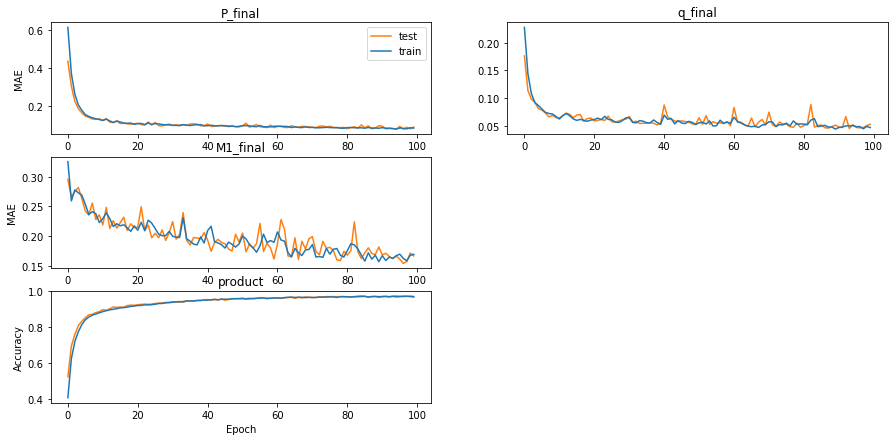

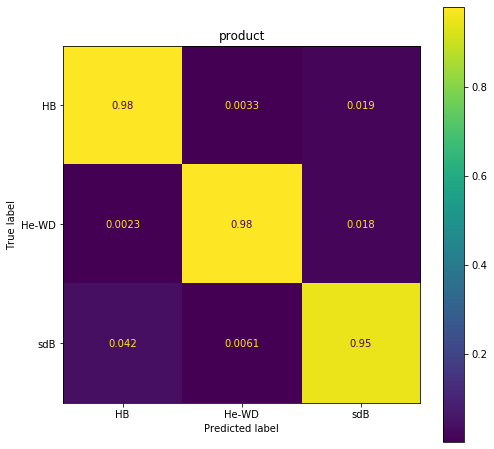

In [18]:
pl.figure(figsize=(15,7))
predictor_stable.print_score()
predictor_stable.plot_training_history()
pl.figure(figsize=(8, 8))
predictor_stable.plot_confusion_matrix()

In [19]:
predictor_stable.save_model('model_stable_systems.h5')

## Predict properties for unstable systems

Oversample the sdBs

In [20]:
df_ce['product'].value_counts()

He-WD    9397
HB       1102
sdB       821
Name: product, dtype: int64

In [21]:
df_ce_sdb = df_ce[df_ce['product'] == 'sdB'].sample(3000, replace=True)
df_ce_wd = df_ce[df_ce['product'] == 'He-WD'].sample(5000, replace=True)
df_ce_hb = df_ce[df_ce['product'] == 'HB']
df_ce_resampled = pd.concat([df_ce_sdb, df_ce_wd, df_ce_hb])
df_ce_resampled['product'].value_counts()

He-WD    5000
sdB      3000
HB       1102
Name: product, dtype: int64

In [22]:
setup = """
features: 
    - M1_init
    - q_init
    - P_init
    - FeH_init
    - stability_limit
    - alpha_ce
regressors:
    P_final:
        processor: StandardScaler
    q_final:
        processor: StandardScaler
    M1_final:
        processor: StandardScaler
classifiers:
    - product
model:
   - {'layer':'Dense',   'args':[300], 'kwargs': {'activation':'relu', 'name':'FC_1'} }
   - {'layer':'Dropout', 'args':[0.1], 'kwargs': {'name':'DO_1'} }
   - {'layer':'Dense',   'args':[200], 'kwargs': {'activation':'relu', 'name':'FC_2'} }
   - {'layer':'Dense',   'args':[100], 'kwargs': {'activation':'relu', 'name':'FC_3'} }
   - {'layer':'Dense',   'args':[50],  'kwargs': {'activation':'relu', 'name':'FC_4'} }
   
optimizer: adam
"""
setup = yaml.safe_load(setup)
predictor_ce = predictors.FCPredictor(setup=setup, data=df_ce_resampled)

In [23]:
predictor_ce.fit(epochs=100, batch_size=1024, reduce_lr=True)

Train on 7281 samples, validate on 1821 samples
Epoch 1/100
 - 3s - loss: 3.4826 - P_final_loss: 0.9299 - q_final_loss: 0.6915 - M1_final_loss: 0.6673 - product_loss: 1.0891 - P_final_mae: 0.5107 - q_final_mae: 0.5341 - M1_final_mae: 0.7439 - product_accuracy: 0.4182 - val_loss: 2.4070 - val_P_final_loss: 0.7004 - val_q_final_loss: 0.3934 - val_M1_final_loss: 0.2638 - val_product_loss: 1.0292 - val_P_final_mae: 0.4769 - val_q_final_mae: 0.4037 - val_M1_final_mae: 0.4245 - val_product_accuracy: 0.6886
Epoch 2/100
 - 1s - loss: 2.2211 - P_final_loss: 0.7766 - q_final_loss: 0.2333 - M1_final_loss: 0.2217 - product_loss: 0.9259 - P_final_mae: 0.5075 - q_final_mae: 0.3312 - M1_final_mae: 0.3688 - product_accuracy: 0.7212 - val_loss: 1.7454 - val_P_final_loss: 0.5747 - val_q_final_loss: 0.1936 - val_M1_final_loss: 0.1664 - val_product_loss: 0.8003 - val_P_final_mae: 0.4313 - val_q_final_mae: 0.3002 - val_M1_final_mae: 0.3116 - val_product_accuracy: 0.7315
Epoch 3/100
 - 0s - loss: 1.7527 - P

Epoch 19/100
 - 0s - loss: 0.3991 - P_final_loss: 0.1595 - q_final_loss: 0.0454 - M1_final_loss: 0.0503 - product_loss: 0.1290 - P_final_mae: 0.1996 - q_final_mae: 0.1276 - M1_final_mae: 0.1484 - product_accuracy: 0.9496 - val_loss: 0.3420 - val_P_final_loss: 0.1288 - val_q_final_loss: 0.0420 - val_M1_final_loss: 0.0437 - val_product_loss: 0.1215 - val_P_final_mae: 0.1874 - val_q_final_mae: 0.1233 - val_M1_final_mae: 0.1393 - val_product_accuracy: 0.9555
Epoch 20/100
 - 0s - loss: 0.3657 - P_final_loss: 0.1471 - q_final_loss: 0.0436 - M1_final_loss: 0.0419 - product_loss: 0.1258 - P_final_mae: 0.1999 - q_final_mae: 0.1256 - M1_final_mae: 0.1361 - product_accuracy: 0.9539 - val_loss: 0.3236 - val_P_final_loss: 0.1217 - val_q_final_loss: 0.0378 - val_M1_final_loss: 0.0380 - val_product_loss: 0.1202 - val_P_final_mae: 0.1681 - val_q_final_mae: 0.1111 - val_M1_final_mae: 0.1182 - val_product_accuracy: 0.9555
Epoch 21/100
 - 0s - loss: 0.3361 - P_final_loss: 0.1381 - q_final_loss: 0.0414 - 

Epoch 37/100
 - 0s - loss: 0.2413 - P_final_loss: 0.0898 - q_final_loss: 0.0251 - M1_final_loss: 0.0249 - product_loss: 0.0901 - P_final_mae: 0.1434 - q_final_mae: 0.0940 - M1_final_mae: 0.0950 - product_accuracy: 0.9677 - val_loss: 0.2250 - val_P_final_loss: 0.0808 - val_q_final_loss: 0.0207 - val_M1_final_loss: 0.0225 - val_product_loss: 0.0958 - val_P_final_mae: 0.1258 - val_q_final_mae: 0.0737 - val_M1_final_mae: 0.0847 - val_product_accuracy: 0.9649
Epoch 38/100
 - 0s - loss: 0.2476 - P_final_loss: 0.0943 - q_final_loss: 0.0259 - M1_final_loss: 0.0263 - product_loss: 0.0976 - P_final_mae: 0.1379 - q_final_mae: 0.0917 - M1_final_mae: 0.0962 - product_accuracy: 0.9648 - val_loss: 0.2218 - val_P_final_loss: 0.0843 - val_q_final_loss: 0.0204 - val_M1_final_loss: 0.0215 - val_product_loss: 0.0918 - val_P_final_mae: 0.1405 - val_q_final_mae: 0.0776 - val_M1_final_mae: 0.0843 - val_product_accuracy: 0.9687
Epoch 39/100
 - 0s - loss: 0.2438 - P_final_loss: 0.1194 - q_final_loss: 0.0249 - 

Epoch 55/100
 - 1s - loss: 0.1967 - P_final_loss: 0.0691 - q_final_loss: 0.0181 - M1_final_loss: 0.0188 - product_loss: 0.0904 - P_final_mae: 0.1142 - q_final_mae: 0.0797 - M1_final_mae: 0.0785 - product_accuracy: 0.9685 - val_loss: 0.1740 - val_P_final_loss: 0.0597 - val_q_final_loss: 0.0163 - val_M1_final_loss: 0.0139 - val_product_loss: 0.0802 - val_P_final_mae: 0.0923 - val_q_final_mae: 0.0703 - val_M1_final_mae: 0.0604 - val_product_accuracy: 0.9736
Epoch 56/100
 - 0s - loss: 0.1942 - P_final_loss: 0.0694 - q_final_loss: 0.0218 - M1_final_loss: 0.0175 - product_loss: 0.0842 - P_final_mae: 0.1166 - q_final_mae: 0.0818 - M1_final_mae: 0.0743 - product_accuracy: 0.9691 - val_loss: 0.1868 - val_P_final_loss: 0.0651 - val_q_final_loss: 0.0152 - val_M1_final_loss: 0.0150 - val_product_loss: 0.0856 - val_P_final_mae: 0.0937 - val_q_final_mae: 0.0601 - val_M1_final_mae: 0.0638 - val_product_accuracy: 0.9720
Epoch 57/100
 - 1s - loss: 0.1987 - P_final_loss: 0.0684 - q_final_loss: 0.0212 - 

Epoch 73/100
 - 0s - loss: 0.1642 - P_final_loss: 0.0528 - q_final_loss: 0.0150 - M1_final_loss: 0.0145 - product_loss: 0.0701 - P_final_mae: 0.0962 - q_final_mae: 0.0720 - M1_final_mae: 0.0697 - product_accuracy: 0.9727 - val_loss: 0.1551 - val_P_final_loss: 0.0504 - val_q_final_loss: 0.0125 - val_M1_final_loss: 0.0126 - val_product_loss: 0.0752 - val_P_final_mae: 0.0806 - val_q_final_mae: 0.0548 - val_M1_final_mae: 0.0562 - val_product_accuracy: 0.9769
Epoch 74/100
 - 0s - loss: 0.1554 - P_final_loss: 0.0500 - q_final_loss: 0.0156 - M1_final_loss: 0.0145 - product_loss: 0.0730 - P_final_mae: 0.0967 - q_final_mae: 0.0710 - M1_final_mae: 0.0679 - product_accuracy: 0.9739 - val_loss: 0.1568 - val_P_final_loss: 0.0506 - val_q_final_loss: 0.0124 - val_M1_final_loss: 0.0127 - val_product_loss: 0.0768 - val_P_final_mae: 0.0804 - val_q_final_mae: 0.0550 - val_M1_final_mae: 0.0564 - val_product_accuracy: 0.9736
Epoch 75/100
 - 0s - loss: 0.1615 - P_final_loss: 0.0514 - q_final_loss: 0.0151 - 

Epoch 91/100
 - 0s - loss: 0.1532 - P_final_loss: 0.0491 - q_final_loss: 0.0181 - M1_final_loss: 0.0153 - product_loss: 0.0713 - P_final_mae: 0.0934 - q_final_mae: 0.0696 - M1_final_mae: 0.0659 - product_accuracy: 0.9739 - val_loss: 0.1537 - val_P_final_loss: 0.0501 - val_q_final_loss: 0.0117 - val_M1_final_loss: 0.0123 - val_product_loss: 0.0749 - val_P_final_mae: 0.0777 - val_q_final_mae: 0.0539 - val_M1_final_mae: 0.0553 - val_product_accuracy: 0.9725
Epoch 92/100
 - 0s - loss: 0.1570 - P_final_loss: 0.0493 - q_final_loss: 0.0151 - M1_final_loss: 0.0142 - product_loss: 0.0708 - P_final_mae: 0.0952 - q_final_mae: 0.0698 - M1_final_mae: 0.0674 - product_accuracy: 0.9739 - val_loss: 0.1537 - val_P_final_loss: 0.0500 - val_q_final_loss: 0.0118 - val_M1_final_loss: 0.0123 - val_product_loss: 0.0749 - val_P_final_mae: 0.0777 - val_q_final_mae: 0.0539 - val_M1_final_mae: 0.0551 - val_product_accuracy: 0.9725
Epoch 93/100
 - 0s - loss: 0.1573 - P_final_loss: 0.0471 - q_final_loss: 0.0164 - 

Training results
target           mean  training score   test score
--------------------------------------------------
P_final     :   56.681        9.953       10.983
q_final     :    1.986        0.102        0.112
M1_final    :    0.963        0.038        0.041
product     :  -        97.9%        97.3%


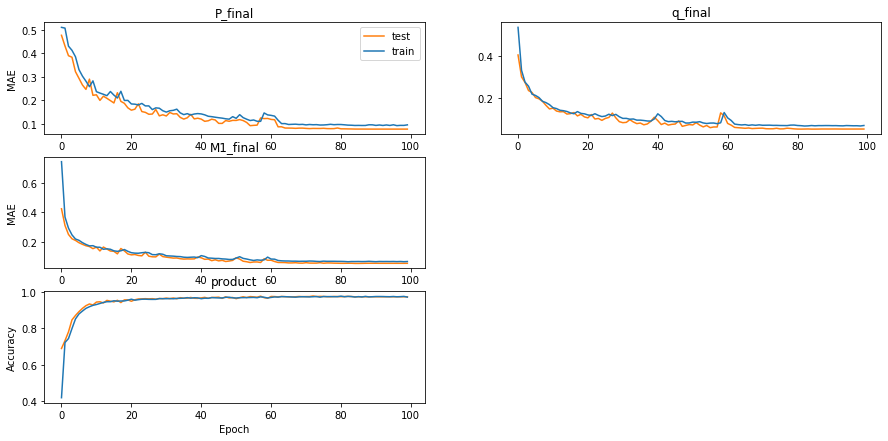

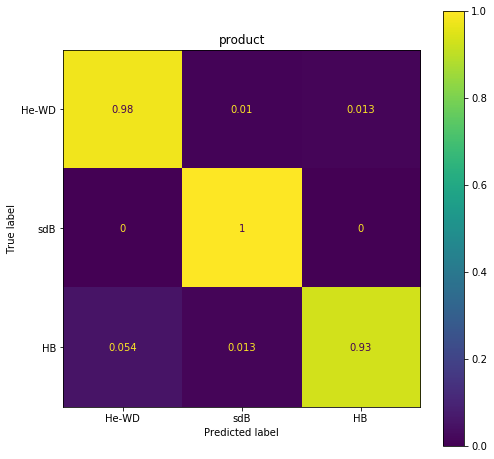

In [24]:
pl.figure(figsize=(15,7))
predictor_ce.print_score()
predictor_ce.plot_training_history()
pl.figure(figsize=(8, 8))
predictor_ce.plot_confusion_matrix()

In [25]:
predictor_ce.save_model('model_ce_systems.h5')